## Contents

1. [Preprocessing Tweets](#preprocessing-tweets)

In [191]:
import pandas as pd
import numpy as np
import nltk
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tag import pos_tag
from nltk.corpus import wordnet
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('punkt');

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/michaelromanski/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelromanski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaelromanski/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Preprocessing Tweets

In [192]:
df = pd.read_csv("data/tweets.csv", encoding='ISO-8859-1')

df.columns = ["unprocessed_tweet", "product", "emotion"]

df.head(3)

,unprocessed_tweet,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion


In [193]:
text = df["unprocessed_tweet"]
text

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
9088                        Ipad everywhere. #SXSW {link}
9089    Wave, buzz... RT @mention We interrupt your re...
9090    Google's Zeiger, a physician never reported po...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: unprocessed_tweet, Length: 9093, dtype: object

In [40]:
from nltk.corpus import stopwords

stop_words = stopwords.words("english")
stop_words = [i.replace("'", '') for i in stop_words]

stop_words[-5:]
top_words = ['sxsw', 'mention', 'link', 'rt']
stop_words = stop_words + top_words

In [41]:
ex = "[^a-zA-Z\s]"

text = text.str.replace(ex, "", regex=True)
text = text.str.lower()
text

0       wesley i have a g iphone after  hrs tweeting a...
1       jessedee know about fludapp  awesome ipadiphon...
2       swonderlin can not wait for ipad  also they sh...
3       sxsw i hope this years festival isnt as crashy...
4       sxtxstate great stuff on fri sxsw marissa maye...
                              ...                        
9088                            ipad everywhere sxsw link
9089    wave buzz rt mention we interrupt your regular...
9090    googles zeiger a physician never reported pote...
9091    some verizon iphone customers complained their...
9092    rt mention google tests checkin offers at sxsw...
Name: unprocessed_tweet, Length: 9093, dtype: object

In [42]:
from nltk.tokenize import word_tokenize

tokenized_text = text.apply(lambda t: word_tokenize(str(t)))
tokenized_text

0       [wesley, i, have, a, g, iphone, after, hrs, tw...
1       [jessedee, know, about, fludapp, awesome, ipad...
2       [swonderlin, can, not, wait, for, ipad, also, ...
3       [sxsw, i, hope, this, years, festival, isnt, a...
4       [sxtxstate, great, stuff, on, fri, sxsw, maris...
                              ...                        
9088                       [ipad, everywhere, sxsw, link]
9089    [wave, buzz, rt, mention, we, interrupt, your,...
9090    [googles, zeiger, a, physician, never, reporte...
9091    [some, verizon, iphone, customers, complained,...
9092    [rt, mention, google, tests, checkin, offers, ...
Name: unprocessed_tweet, Length: 9093, dtype: object

In [43]:
filtered_text = tokenized_text.apply(lambda x: [word for word in x if word not in stop_words])
filtered_text = filtered_text.apply(lambda x: [word for word in x if len(word) > 1])
filtered_text

0       [wesley, iphone, hrs, tweeting, riseaustin, de...
1       [jessedee, know, fludapp, awesome, ipadiphone,...
2                    [swonderlin, wait, ipad, also, sale]
3       [hope, years, festival, crashy, years, iphone,...
4       [sxtxstate, great, stuff, fri, marissa, mayer,...
                              ...                        
9088                                   [ipad, everywhere]
9089    [wave, buzz, interrupt, regularly, scheduled, ...
9090    [googles, zeiger, physician, never, reported, ...
9091    [verizon, iphone, customers, complained, time,...
9092                     [google, tests, checkin, offers]
Name: unprocessed_tweet, Length: 9093, dtype: object

In [44]:
tagged_text = filtered_text.apply(lambda x: pos_tag(x))
tagged_text

0       [(wesley, NN), (iphone, NN), (hrs, NN), (tweet...
1       [(jessedee, NN), (know, VBP), (fludapp, VBZ), ...
2       [(swonderlin, NN), (wait, NN), (ipad, NN), (al...
3       [(hope, NN), (years, NNS), (festival, JJ), (cr...
4       [(sxtxstate, NN), (great, JJ), (stuff, NN), (f...
                              ...                        
9088                       [(ipad, NN), (everywhere, RB)]
9089    [(wave, NN), (buzz, NN), (interrupt, VBP), (re...
9090    [(googles, NNS), (zeiger, RBR), (physician, JJ...
9091    [(verizon, NN), (iphone, NN), (customers, NNS)...
9092    [(google, NN), (tests, NNS), (checkin, VBP), (...
Name: unprocessed_tweet, Length: 9093, dtype: object

In [45]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

lemmatized_text = tagged_text.apply(
    lambda x: [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in x]
)

lemmatized_str = lemmatized_text.apply(lambda x: ' '.join(x))

lemmatized_str

0       wesley iphone hr tweet riseaustin dead need up...
1       jessedee know fludapp awesome ipadiphone app l...
2                          swonderlin wait ipad also sale
3               hope year festival crashy year iphone app
4       sxtxstate great stuff fri marissa mayer google...
                              ...                        
9088                                      ipad everywhere
9089    wave buzz interrupt regularly schedule geek pr...
9090    google zeiger physician never report potential...
9091    verizon iphone customer complain time fell bac...
9092                            google test checkin offer
Name: unprocessed_tweet, Length: 9093, dtype: object

In [46]:
lemmatized_text

0       [wesley, iphone, hr, tweet, riseaustin, dead, ...
1       [jessedee, know, fludapp, awesome, ipadiphone,...
2                    [swonderlin, wait, ipad, also, sale]
3       [hope, year, festival, crashy, year, iphone, app]
4       [sxtxstate, great, stuff, fri, marissa, mayer,...
                              ...                        
9088                                   [ipad, everywhere]
9089    [wave, buzz, interrupt, regularly, schedule, g...
9090    [google, zeiger, physician, never, report, pot...
9091    [verizon, iphone, customer, complain, time, fe...
9092                       [google, test, checkin, offer]
Name: unprocessed_tweet, Length: 9093, dtype: object

In [47]:
df["processed_tweet"] = lemmatized_str
df.head()

,unprocessed_tweet,product,emotion,processed_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley iphone hr tweet riseaustin dead need up...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know fludapp awesome ipadiphone app l...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff fri marissa mayer google...


In [48]:
df['emotion'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [49]:
df.to_csv("data/processed_tweets.csv")

In [50]:
df_binary = df.copy()
df_binary = df_binary[df_binary["emotion"].isin(["Negative emotion", "Positive emotion"])]

df_binary["emotion_encoded"] = df_binary["emotion"].replace("Negative emotion", 0).replace("Positive emotion", 1)
df_binary.to_csv("data/processed_tweets_binary.csv")

In [51]:
df_binary

,unprocessed_tweet,product,emotion,processed_tweet,emotion_encoded
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley iphone hr tweet riseaustin dead need up...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know fludapp awesome ipadiphone app l...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin wait ipad also sale,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone app,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff fri marissa mayer google...,1
...,...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion,pr guy convince switch back iphone great cover...,1
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion,quotpapyrussort like ipadquot nice lol lavelle,1
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion,diller say google tv quotmight run playstation...,0
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion,ive always use camera iphone bc image stabiliz...,1


In [52]:
df_binary['emotion_encoded'].value_counts()

1    2978
0     570
Name: emotion_encoded, dtype: int64

In [53]:
X = df_binary['processed_tweet']
y = df_binary['emotion_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [54]:
bin_forest_pipe = Pipeline([
    ('tf', TfidfVectorizer(min_df=.01, max_df=.9, stop_words=stop_words)),
    ('rf', RandomForestClassifier(random_state=42))
])

In [55]:
bin_forest_pipe.fit(X_train, y_train)

y_pred_forest = bin_forest_pipe.predict(X_test)
forest_test_acc = accuracy_score(y_test, y_pred_forest)
forest_test_acc

0.8577464788732394

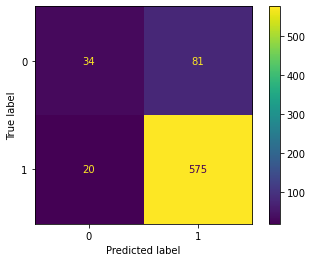

In [56]:
cfm_forest = confusion_matrix(y_test, y_pred_forest)
ConfusionMatrixDisplay(cfm_forest).plot()

In [57]:
y_test

685     1
6393    1
7851    0
5813    0
2944    1
       ..
2707    1
2770    1
6653    1
2127    1
5565    0
Name: emotion_encoded, Length: 710, dtype: int64

In [58]:
forest_score = cross_val_score(bin_forest_pipe, X_train, y_train, cv=5)
forest_score

array([0.85211268, 0.84859155, 0.8556338 , 0.86419753, 0.85361552])

In [59]:
bin_forest_pipe_grid = Pipeline([
    ('tf', TfidfVectorizer(stop_words=stop_words)),
    ('rf', RandomForestClassifier(random_state=42))
    
])

In [60]:
forest_param_grid = {
    'tf__min_df': [.01, .02, .03],
    'tf__max_df': [.88, .90, .92],
    'tf__ngram_range': [(1,1), (1,2), (1,3)],
    'rf__n_estimators': [86, 88, 90],
    'rf__min_samples_split': [10, 20, 30],
    'rf__class_weight': [None, 'balanced', 'balanced_subsample']
    
}

In [61]:
forest_param_grid = {
    'tf__min_df': [.01, .02, .03],
    'tf__max_df': [.88, .90, .92],
    'tf__ngram_range': [(1,1), (2,2), (3,3)],
    'rf__n_estimators': [86, 88, 90],
    'rf__min_samples_split': [10, 20, 30],
    'rf__class_weight': [None, 'balanced', 'balanced_subsample']
    
}

In [62]:
bin_forest_grid = GridSearchCV(bin_forest_pipe_grid, forest_param_grid, cv=5, n_jobs=-2, verbose=1, scoring='accuracy')
bin_forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
405 fits failed out of a total of 3645.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    'youre',
                                                                    'youve',
                                                                    'youll',
                                                                    'youd',
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    'shes',
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it', 'its',
                                                                    'its',
                                                                    'itself', ...])),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-2,
             param_grid={'rf__class_weight': [None, 'balanced',
                                              'balanced_subsample'],
                         'rf__min_samples_split': [10, 20, 30],
                         'rf__n_estimators': [86, 88, 90],
                         'tf__max_df': [0.88, 0.9, 0.92],
                         'tf__min_df': [0.01, 0.02, 0.03],
                         'tf__ngram_range': [(1, 1), (2, 2), (3, 3)]},
             scoring='accuracy', verbose=1)

In [63]:
print(bin_forest_grid.best_estimator_)
print(bin_forest_grid.best_params_)
print(bin_forest_grid.best_score_)


Pipeline(steps=[('tf',
                 TfidfVectorizer(max_df=0.88, min_df=0.01,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             'youre', 'youve', 'youll', 'youd',
                                             'your', 'yours', 'yourself',
                                             'yourselves', 'he', 'him', 'his',
                                             'himself', 'she', 'shes', 'her',
                                             'hers', 'herself', 'it', 'its',
                                             'its', 'itself', ...])),
                ('rf',
                 RandomForestClassifier(min_samples_split=10, n_estimators=86,
                                        random_state=42))])
{'rf__class_weight': None, 'rf__min_samples_split': 10, 'rf__n_estimators': 86, 'tf__max_df': 0.88, 'tf__min_df': 0.01, 'tf__ngram_range': (

In [64]:
# Extract the TfidfVectorizer from the pipeline
tf_vec = bin_forest_pipe_grid.named_steps['tf']

# Fit the TfidfVectorizer on the training data
tf_vec.fit(X_train)

# Transform the training data using the fitted TfidfVectorizer
X_train_tf = tf_vec.transform(X_train)

# Get the feature names from the TfidfVectorizer
feature_names = tf_vec.get_feature_names_out()

# Extract the RandomForestClassifier from the pipeline
rf = bin_forest_pipe_grid.named_steps['rf']

# Fit the RandomForestClassifier on the transformed training data
rf.fit(X_train_tf, y_train)

# Get the feature importances from the fitted RandomForestClassifier
feature_importances = rf.feature_importances_

# Create a DataFrame with the feature names and their corresponding importances
importances_df = pd.DataFrame({"feature_names": feature_names, "importances": feature_importances})

In [65]:
sorted_importances = importances_df.sort_values(by='importances', ascending=False)
sorted_importances = sorted_importances.head(20)

In [66]:
sorted_importances.to_csv('data/importances.csv')

In [157]:
sentiment = df_binary[['emotion_encoded', 'product']]
sentiment

,emotion_encoded,product
0,0,iPhone
1,1,iPad or iPhone App
2,1,iPad
3,0,iPad or iPhone App
4,1,Google
...,...,...
9077,1,iPhone
9079,1,iPad
9080,0,Other Google product or service
9085,1,iPad or iPhone App


In [158]:
sentiment[sentiment['emotion_encoded'] == 1].value_counts()

emotion_encoded  product                        
1                iPad                               793
                 Apple                              543
                 iPad or iPhone App                 397
                 Google                             346
                 Other Google product or service    236
                 iPhone                             184
                 Android App                         72
                 Android                             69
                 Other Apple product or service      32
dtype: int64

In [159]:
apple_prod = ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service']
mask = sentiment[sentiment['product'].isin(apple_prod)]
mask['emotion_encoded'].value_counts()

1    1949
0     388
Name: emotion_encoded, dtype: int64

In [161]:
tot_apple_review = len(mask)
pos_apple_review = 1949/tot_apple_review
neg_apple_review = 1 - pos_apple_review
print(pos_apple_review, neg_apple_review)

0.8339751818570817 0.16602481814291825


In [162]:
tot_apple_review

2337

In [163]:
google_prod = ['Google', 'Other Google product or service', 'Android App', 'Android']
g_mask = sentiment[sentiment['product'].isin(google_prod)]
g_mask['emotion_encoded'].value_counts()

1    723
0    131
Name: emotion_encoded, dtype: int64

In [164]:
tot_google_review = len(g_mask)
pos_google_review = 723/tot_google_review
neg_google_review = 1 - pos_google_review
print(pos_google_review, neg_google_review)


0.8466042154566745 0.15339578454332548


In [165]:
tot_google_review

854

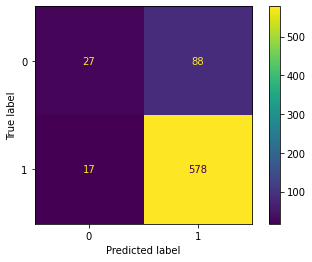

In [82]:
y_pred_forest_grid = bin_forest_grid.predict(X_test)
cfm_forest = confusion_matrix(y_test, y_pred_forest_grid)
ConfusionMatrixDisplay(cfm_forest).plot()

In [83]:

forest_grid_test_acc = accuracy_score(y_test, y_pred_forest_grid)
forest_grid_test_acc 

0.852112676056338

---

In [ ]:
bin_log_pipe = Pipeline([
    ('tf', TfidfVectorizer(min_df=.01, max_df=.9, stop_words=stop_words)),
    ('lr', LogisticRegression(random_state=42))
])

In [ ]:
bin_log_pipe.fit(X_train, y_train)

y_pred_log = bin_log_pipe.predict(X_test)
log_test_acc = accuracy_score(y_test, y_pred_log)
log_test_acc

In [ ]:
cfm_log = confusion_matrix(y_test, y_pred_log)
ConfusionMatrixDisplay(cfm_log).plot()

In [ ]:
log_score = cross_val_score(bin_log_pipe, X_train, y_train, cv=5)
log_score

In [ ]:
bin_log_pipe_grid = Pipeline([
    ('tf', TfidfVectorizer(stop_words=stop_words)),
    ('lr', LogisticRegression(random_state=42))
])

In [ ]:
log_param_grid = {
    'tf__min_df': [.01, .02, .03],
    'tf__max_df': [.88, .90, .92],
    'tf__ngram_range': [(1,1), (2,2), (3,3)],
    'lr__penalty': [None, 'l2', 'l1'],
    'lr__class_weight': [None, 'balanced'],
    'lr__solver': ['lbfgs', 'liblinear'],
    'lr__max_iter': [10, 15, 20]
}

In [ ]:
bin_log_grid = GridSearchCV(bin_log_pipe_grid, log_param_grid, cv=5, n_jobs=-2, verbose=1, scoring='accuracy')
bin_log_grid.fit(X_train, y_train)

In [ ]:
print(bin_log_grid.best_params_)
print(bin_log_grid.best_score_)

In [ ]:
y_pred_log_grid = bin_log_grid.predict(X_test)
log_test_acc = accuracy_score(y_test, y_pred_log_grid)
log_test_acc

In [ ]:
cfm_log = confusion_matrix(y_test, y_pred_log_grid)
ConfusionMatrixDisplay(cfm_log).plot()

In [ ]:
log_score = cross_val_score(bin_log_grid, X_train, y_train, cv=5)
log_score

In [ ]:
tf = TfidfVectorizer(min_df = .01, max_df = .9)

X_train_tf = tf.fit_transform(X_train.values)
X_train_tf = X_train_tf.toarray()
X_test_tf = tf.transform(X_test.values)
X_test_tf = X_test_tf.toarray()

In [ ]:
nb_model = GaussianNB()

In [ ]:
nb_model.fit(X_train_tf, y_train)

y_pred_nb = nb_model.predict(X_test_tf)
nb_test_acc = accuracy_score(y_test, y_pred_nb)
nb_test_acc

In [ ]:
cfm_nb = confusion_matrix(y_test, y_pred_nb)
ConfusionMatrixDisplay(cfm_nb).plot()

In [ ]:
print(classification_report(y_test,y_pred_nb))

In [ ]:
nb_pipe = Pipeline([
    ('nb', GaussianNB())
])

nb_param_grid = {
    'nb__var_smoothing': [1e-8, 1e-9, 1e-10]
}

In [ ]:
nb_grid = GridSearchCV(nb_pipe, nb_param_grid, cv=5, n_jobs=2)
nb_grid.fit(X_train_tf, y_train)

In [ ]:
print(nb_grid.best_params_)
print(nb_grid.best_score_)

In [84]:
df_binary['list_tokens'] = lemmatized_text

In [85]:
df_binary

,unprocessed_tweet,product,emotion,processed_tweet,emotion_encoded,list_tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley iphone hr tweet riseaustin dead need up...,0,"[wesley, iphone, hr, tweet, riseaustin, dead, ..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know fludapp awesome ipadiphone app l...,1,"[jessedee, know, fludapp, awesome, ipadiphone,..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin wait ipad also sale,1,"[swonderlin, wait, ipad, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone app,0,"[hope, year, festival, crashy, year, iphone, app]"
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff fri marissa mayer google...,1,"[sxtxstate, great, stuff, fri, marissa, mayer,..."
...,...,...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion,pr guy convince switch back iphone great cover...,1,"[pr, guy, convince, switch, back, iphone, grea..."
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion,quotpapyrussort like ipadquot nice lol lavelle,1,"[quotpapyrussort, like, ipadquot, nice, lol, l..."
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion,diller say google tv quotmight run playstation...,0,"[diller, say, google, tv, quotmight, run, play..."
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion,ive always use camera iphone bc image stabiliz...,1,"[ive, always, use, camera, iphone, bc, image, ..."


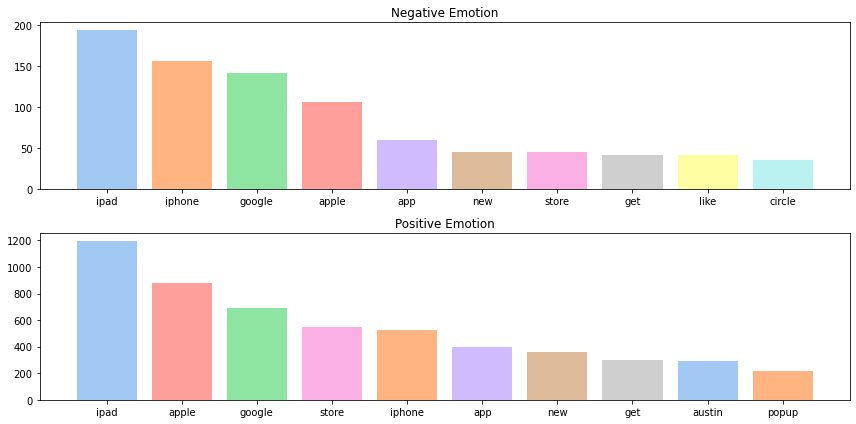

In [86]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 6))

plotted_words_and_colors = {}

color_palette = sns.color_palette('pastel', n_colors = 38)

data_by_emotion = [y for _, y in df_binary.groupby('emotion_encoded', as_index=False)]
for idx, emotion_df in enumerate(data_by_emotion):
    all_words_in_emotion = emotion_df.list_tokens.explode()
    top_10 = all_words_in_emotion.value_counts()[:10]
    
    colors = []
    for word in top_10.index:
        if word not in plotted_words_and_colors:
             new_color = color_palette.pop(0)
             plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
            
    ax = axes[idx]
    ax.bar(top_10.index, top_10.values, color=colors)
    ax.set_title(emotion_df.iloc[0].emotion.title())
    
fig.tight_layout()

In [87]:
top_10

ipad      1196
apple      881
google     692
store      549
iphone     522
app        395
new        360
get        301
austin     290
popup      218
Name: list_tokens, dtype: int64

In [119]:
data = pd.read_csv("data/processed_tweets.csv", index_col=0)

data["product"].value_counts()

data_branded = data.copy()

mapping = {
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'iPhone': 'Apple',
    'Other Apple product or service': 'Apple',
    'Google': 'Google',
    'Other Google product or service': 'Google',
    'Android App': 'Google',
    'Android': 'Google'
}

data_branded["product"] = data_branded["product"].map(mapping)

data_branded.isnull().sum()

data_branded["product"].value_counts()

data_branded[data_branded['product'].isna()]

apple_keywords = ['iPad', 'Apple', 'iPhone']
google_keywords = ['Google', 'Android']

for keyword in apple_keywords:
    mask = (data_branded['product'].isna()) & (data_branded['unprocessed_tweet'].str.contains(keyword, case=False, na=False))
    data_branded.loc[mask, 'product'] = 'Apple'

for keyword in google_keywords:
    mask = (data_branded['product'].isna()) & (data_branded['unprocessed_tweet'].str.contains(keyword, case=False, na=False))
    data_branded.loc[mask, 'product'] = 'Google'

data_branded.isnull().sum()

data_branded.dropna()

data_branded.dropna().to_csv("data/branded.csv")

In [120]:
data_branded['emotion'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [121]:
data_branded.isna().sum()

unprocessed_tweet      1
product              762
emotion                0
processed_tweet        2
dtype: int64

In [122]:
data_branded.dropna(inplace=True)

In [134]:
neutral_data = data_branded[data_branded["emotion"] == 'No emotion toward brand or product']

In [205]:
neutral_data.head(30)

,unprocessed_tweet,product,emotion,processed_tweet,emotion_encoded
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Apple,No emotion toward brand or product,teachntech new ipad apps speechtherapy communi...,1
16,Holler Gram for iPad on the iTunes App Store -...,Apple,No emotion toward brand or product,holler gram ipad itunes app store httptcokfnfq...,1
32,"Attn: All #SXSW frineds, @mention Register fo...",Google,No emotion toward brand or product,attn frineds register gdgtlive see cobra irada...,1
33,Anyone at #sxsw want to sell their old iPad?,Apple,No emotion toward brand or product,anyone want sell old ipad,1
34,Anyone at #SXSW who bought the new iPad want ...,Apple,No emotion toward brand or product,anyone buy new ipad want sell old ipad,1
35,At #sxsw. Oooh. RT @mention Google to Launch ...,Google,No emotion toward brand or product,oooh google launch major new social network ca...,1
37,SPIN Play - a new concept in music discovery f...,Apple,No emotion toward brand or product,spin play new concept music discovery ipad amp...,1
39,VatorNews - Google And Apple Force Print Media...,Apple,No emotion toward brand or product,vatornews google apple force print medium evolve,1
41,HootSuite - HootSuite Mobile for #SXSW ~ Updat...,Apple,No emotion toward brand or product,hootsuite hootsuite mobile update iphone black...,1
42,Hey #SXSW - How long do you think it takes us ...,Apple,No emotion toward brand or product,hey long think take u make iphone case answer ...,1


In [228]:
neutral_df['unprocessed_tweet'][105]

'.@mention &quot;Google launched checkins a month ago.&quot; Check ins are ok, but CHECK OUTS are the future. #sxsw #Bizzy (via @mention'

In [136]:
neutral_test = neutral_data['processed_tweet']

In [126]:
neutral_test.isna().sum()

0

In [127]:
y_pred_neutral = bin_forest_grid.predict(neutral_test)
y_pred_neutral

array([1, 1, 1, ..., 1, 1, 1])

In [139]:
neutral_df = neutral_data
neutral_data

,unprocessed_tweet,product,emotion,processed_tweet
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Apple,No emotion toward brand or product,teachntech new ipad apps speechtherapy communi...
16,Holler Gram for iPad on the iTunes App Store -...,Apple,No emotion toward brand or product,holler gram ipad itunes app store httptcokfnfq...
32,"Attn: All #SXSW frineds, @mention Register fo...",Google,No emotion toward brand or product,attn frineds register gdgtlive see cobra irada...
33,Anyone at #sxsw want to sell their old iPad?,Apple,No emotion toward brand or product,anyone want sell old ipad
34,Anyone at #SXSW who bought the new iPad want ...,Apple,No emotion toward brand or product,anyone buy new ipad want sell old ipad
...,...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",Google,No emotion toward brand or product,yup third app yet im android suggestion cc
9089,"Wave, buzz... RT @mention We interrupt your re...",Google,No emotion toward brand or product,wave buzz interrupt regularly schedule geek pr...
9090,"Google's Zeiger, a physician never reported po...",Google,No emotion toward brand or product,google zeiger physician never report potential...
9091,Some Verizon iPhone customers complained their...,Apple,No emotion toward brand or product,verizon iphone customer complain time fell bac...


'SPIN Play - a new concept in music discovery for your iPad from @mention &amp; spin.com {link} #iTunes #sxsw @mention'

In [140]:
neutral_test

5       teachntech new ipad apps speechtherapy communi...
16      holler gram ipad itunes app store httptcokfnfq...
32      attn frineds register gdgtlive see cobra irada...
33                              anyone want sell old ipad
34                 anyone buy new ipad want sell old ipad
                              ...                        
9087           yup third app yet im android suggestion cc
9089    wave buzz interrupt regularly schedule geek pr...
9090    google zeiger physician never report potential...
9091    verizon iphone customer complain time fell bac...
9092                            google test checkin offer
Name: processed_tweet, Length: 4647, dtype: object

In [141]:
neutral_df['emotion_encoded'] = y_pred_neutral
neutral_df

<ipython-input-141-2f5b99619a49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neutral_df['emotion_encoded'] = y_pred_neutral


,unprocessed_tweet,product,emotion,processed_tweet,emotion_encoded
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Apple,No emotion toward brand or product,teachntech new ipad apps speechtherapy communi...,1
16,Holler Gram for iPad on the iTunes App Store -...,Apple,No emotion toward brand or product,holler gram ipad itunes app store httptcokfnfq...,1
32,"Attn: All #SXSW frineds, @mention Register fo...",Google,No emotion toward brand or product,attn frineds register gdgtlive see cobra irada...,1
33,Anyone at #sxsw want to sell their old iPad?,Apple,No emotion toward brand or product,anyone want sell old ipad,1
34,Anyone at #SXSW who bought the new iPad want ...,Apple,No emotion toward brand or product,anyone buy new ipad want sell old ipad,1
...,...,...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",Google,No emotion toward brand or product,yup third app yet im android suggestion cc,1
9089,"Wave, buzz... RT @mention We interrupt your re...",Google,No emotion toward brand or product,wave buzz interrupt regularly schedule geek pr...,1
9090,"Google's Zeiger, a physician never reported po...",Google,No emotion toward brand or product,google zeiger physician never report potential...,1
9091,Some Verizon iPhone customers complained their...,Apple,No emotion toward brand or product,verizon iphone customer complain time fell bac...,1


In [147]:
neutral_df['product'].value_counts()

Apple     2875
Google    1772
Name: product, dtype: int64

In [151]:
n_sentiment = neutral_df[['emotion_encoded', 'product']]
n_sentiment

,emotion_encoded,product
5,1,Apple
16,1,Apple
32,1,Google
33,1,Apple
34,1,Apple
...,...,...
9087,1,Google
9089,1,Google
9090,1,Google
9091,1,Apple


In [153]:
n_apple = n_sentiment[n_sentiment['product'] == 'Apple']
n_apple['emotion_encoded'].value_counts()

1    2753
0     122
Name: emotion_encoded, dtype: int64

In [154]:
n_google = n_sentiment[n_sentiment['product'] == 'Google']
n_google['emotion_encoded'].value_counts()

1    1654
0     118
Name: emotion_encoded, dtype: int64

In [169]:
apple_t = len(n_apple)
apple_p = 2753/apple_t
apple_n = 1 - apple_p

In [170]:
google_t = len(n_google)
google_p = 1654/google_t
google_n = 1 - google_p

In [177]:
review_df

,index,Positive Review Percentage,Negative Review Percentage,Brand
0,0,0.833975,0.166025,Apple
1,1,0.846604,0.153396,Google
2,2,0.957565,0.042435,Apple
3,3,0.933409,0.066591,Google


In [150]:
neutral_df[neutral_df['emotion_encoded'] == 0]

,unprocessed_tweet,product,emotion,processed_tweet,emotion_encoded
123,Funny how #Austin is trending but not #SXSW. O...,Apple,No emotion toward brand or product,funny austin trend matter minute point least a...,0
312,Those who are tweeting that Google is coming o...,Google,No emotion toward brand or product,tweet google come circle platform today outsid...,0
330,Long line at #sxsw? What Else? Apple Store {l...,Apple,No emotion toward brand or product,long line else apple store,0
401,10 Austin Classics not to be missed at #SXSW. ...,Apple,No emotion toward brand or product,austin classic miss mblogcom twitter iphone pm,0
496,At a DSLR film discussion moderated by Guy Kaw...,Apple,No emotion toward brand or product,dslr film discussion moderate guy kawasaki app...,0
...,...,...,...,...,...
8937,which browser do u prefer? Internet Explorer 9...,Google,No emotion toward brand or product,browser prefer internet explorer google chrome...,0
8953,At the #sxsw Google Blogger/Sketchup party wit...,Google,No emotion toward brand or product,google bloggersketchup party unexpectedly quie...,0
9014,Am I crazy to be thinking about upgrading my i...,Apple,No emotion toward brand or product,crazy think upgrade iphone right,0
9016,smoked way too much yesterday! hahaha #austin...,Google,No emotion toward brand or product,smoked way much yesterday hahaha austin wakenb...,0


In [179]:
idk_data = data_branded[data_branded['emotion'] == "I can't tell"]
idk_test = idk_data['processed_tweet']

In [180]:
y_pred_idk = bin_forest_grid.predict(idk_test)
y_pred_idk

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [181]:
idk_df = idk_data
idk_df['emotion_encoded'] = y_pred_idk
idk_df

<ipython-input-181-014761fcca52>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idk_df['emotion_encoded'] = y_pred_idk


,unprocessed_tweet,product,emotion,processed_tweet,emotion_encoded
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,Apple,I can't tell,quotapple open popup store austin nerd town ge...,1
237,Just what America needs. RT @mention Google to...,Google,I can't tell,america need google launch major new social ne...,0
341,The queue at the Apple Store in Austin is FOUR...,Apple,I can't tell,queue apple store austin four block long crazy...,0
368,Hope it's better than wave RT @mention Buzz is...,Google,I can't tell,hope well wave buzz google preview social netw...,0
413,SYD #SXSW crew your iPhone extra juice pods ha...,Apple,I can't tell,syd crew iphone extra juice pod procure,1
...,...,...,...,...,...
9020,It's funny watching a room full of people hold...,Apple,I can't tell,funny watching room full people hold ipad air ...,1
9032,"@mention yeah, we have @mention , Google has n...",Google,I can't tell,yeah google nothing u,1
9037,"@mention Yes, the Google presentation was not ...",Google,I can't tell,yes google presentation exactly expect,0
9058,&quot;Do you know what Apple is really good at...,Apple,I can't tell,quotdo know apple really good make feel bad xm...,1


In [183]:
idk_df['emotion_encoded'].value_counts()

1    130
0     20
Name: emotion_encoded, dtype: int64

In [185]:
idk_apple = idk_df[idk_df['product'] == 'Apple']
idk_apple['emotion_encoded'].value_counts()

1    85
0    14
Name: emotion_encoded, dtype: int64

In [186]:
idk_google = idk_df[idk_df['product'] == 'Google']
idk_google['emotion_encoded'].value_counts()

1    45
0     6
Name: emotion_encoded, dtype: int64

In [187]:
idk_apple_t = len(idk_apple)
idk_apple_p = 85/idk_apple_t
idk_apple_n = 1 - idk_apple_p

In [188]:
idk_google_t = len(idk_google)
idk_google_p = 45/idk_google_t
idk_google_n = 1 - idk_google_p

In [189]:
review_data = {"Positive Review Percentage": [pos_apple_review, pos_google_review, apple_p, google_p,
                                              idk_apple_p, idk_google_p],
               "Negative Review Percentage": [neg_apple_review, neg_google_review, apple_n, google_n,
                                             idk_apple_n, idk_google_n]
              }
review_df = pd.DataFrame(review_data)
review_df = review_df.reset_index()
review_df['Brand'] = ['Apple', 'Google', 'Apple', 'Google', 'Apple', 'Google']
review_df.to_csv('data/review.csv')

In [190]:
review_df

,index,Positive Review Percentage,Negative Review Percentage,Brand
0,0,0.833975,0.166025,Apple
1,1,0.846604,0.153396,Google
2,2,0.957565,0.042435,Apple
3,3,0.933409,0.066591,Google
4,4,0.858586,0.141414,Apple
5,5,0.882353,0.117647,Google


Negative Tweets about apple that are marked positive

In [ ]:
df['unprocessed_tweet'][9066]

In [ ]:
df['unprocessed_tweet'][9058]

In [ ]:
df['unprocessed_tweet'][102]

In [ ]:
df['unprocessed_tweet'][441]

Negative tweet about Google that was marked positive

In [ ]:
df['unprocessed_tweet'][9032]

Properly labeled negative tweet about apple

In [ ]:
df['unprocessed_tweet'][1670]

In [ ]:
df['unprocessed_tweet'][4002]

Positive tweet about Google marked as negative

In [ ]:
df['unprocessed_tweet'][3855]

Positive tweet about Apple marked as negative

In [ ]:
df['unprocessed_tweet'][4862]

Possibly properly labeled negative google tweet

In [ ]:
df['unprocessed_tweet'][9037]

properly labeled positive tweet about Apple

In [ ]:
df['unprocessed_tweet'][488]

This tweet is interesting, both positive and negative depending on what brand

In [201]:
df['unprocessed_tweet'][705]

'Forgot my iPhone for #sxsw. Android only. Knife to a gun fight'

In [202]:
idk_df[idk_df['emotion_encoded'] == 1].head(60)

,unprocessed_tweet,product,emotion,processed_tweet,emotion_encoded
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,Apple,I can't tell,quotapple open popup store austin nerd town ge...,1
413,SYD #SXSW crew your iPhone extra juice pods ha...,Apple,I can't tell,syd crew iphone extra juice pod procure,1
441,Why Barry Diller thinks iPad only content is n...,Apple,I can't tell,barry diller think ipad content nut,1
488,Gave into extreme temptation at #SXSW and boug...,Apple,I can't tell,give extreme temptation buy ipad impulse,1
640,Catch 22Û_ I mean iPad 2 at #SXSW : {link},Apple,I can't tell,catch mean ipad,1
705,Forgot my iPhone for #sxsw. Android only. Knif...,Apple,I can't tell,forgot iphone android knife gun fight,1
749,Google no lanzara ningun producto en South by ...,Google,I can't tell,google lanzara ningun producto en south southwest,1
882,Comprando mi iPad 2 en el #SXSW (@mention Appl...,Apple,I can't tell,comprando mi ipad en el apple store others,1
1069,I can now say that Google got me drunk #sxsw #...,Google,I can't tell,say google get drunk hckers,1
1087,ipad is a slow resting heartrate #tapworthy #...,Apple,I can't tell,ipad slow rest heartrate tapworthy gsdm leisur...,1


In [178]:
idk_df

NameError: name 'idk_df' is not defined